In [82]:
from torch.utils.data import DataLoader, Dataset, random_split

In [83]:
import pandas as pd
from tqdm import tqdm
import pickle
import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [84]:
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

train_dataloader = pickle.load(train_fh)
test_data = pickle.load(test_fh)

In [85]:
class LegoDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [86]:
import torchvision.transforms as transforms


tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.13, 0.31),
])

train_dataset = LegoDataset(train_dataloader, tfs)
val_dataset = LegoDataset(test_data, tfs)

In [87]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [88]:
X, y = next(iter(train_dataloader))

X.shape, y.shape

(torch.Size([32, 1, 128, 128]), torch.Size([32]))

In [89]:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


def label2text(label):
    if not isinstance(label, int):
        label = label.item()
        
    return class_names[label]

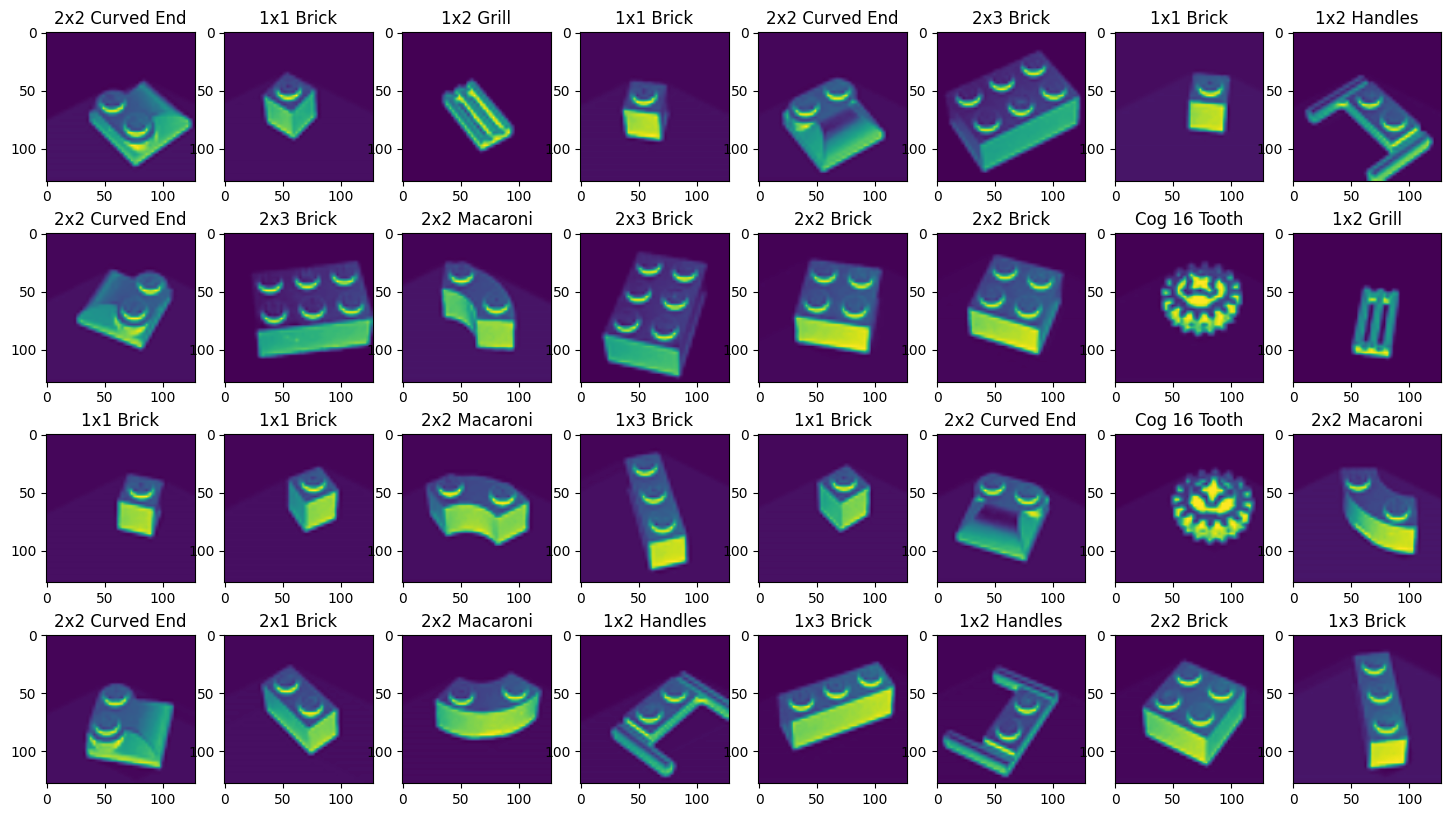

In [103]:
X, y = next(iter(train_dataloader))

rows, cols = 4, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, 10))

for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(X[i].detach().numpy(), (1, 2, 0)))
    axs[r, c].title.set_text(label2text(y[i]))

In [92]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.linear = nn.Sequential(
            nn.Linear(in_features=29*29*16, out_features=5000),
            nn.BatchNorm1d(num_features=5000),
            nn.ReLU(),
            nn.Linear(in_features=5000, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)

        x = x.reshape(-1, 16*29*29)

        return self.linear(x)

In [94]:
def train(model, optim, criterion, train_dataloader, val_dataloader, epoches=10):
    losses = {
        'train': [],
        'val':   []
    }
    
    for epoch in tqdm(range(epoches)):
        # train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_dataloader:
            optim.zero_grad()
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optim.step()
            train_loss += loss.item()
        losses['train'].append(train_loss / len(train_dataloader))
              
        # val
        model.eval()
        val_loss = 0
        for X_batch, y_batch in val_dataloader:
            with torch.no_grad():
                y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            val_loss += loss.item()
        losses['val'].append(val_loss / len(val_dataloader))
        
        print(f'Epoch: {epoch + 1}/{epoches}; train_loss: {train_loss}; val_loss: {val_loss}')

    plt.plot(losses['train'], label='train loss')
    plt.plot(losses['val'],   label='val loss')
    plt.legend()
    return losses

In [95]:
model = CNN().to(device)

In [96]:
optim = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

 25%|██▌       | 1/4 [00:00<00:01,  1.73it/s]

Epoch: 1/4; train_loss: 15.147485673427582; val_loss: 25.51313066482544


 50%|█████     | 2/4 [00:01<00:01,  1.94it/s]

Epoch: 2/4; train_loss: 4.6247700452804565; val_loss: 4.424424231052399


 75%|███████▌  | 3/4 [00:01<00:00,  2.03it/s]

Epoch: 3/4; train_loss: 5.321259440854192; val_loss: 0.8256101906299591


100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

Epoch: 4/4; train_loss: 8.580589508637786; val_loss: 0.3039967268705368


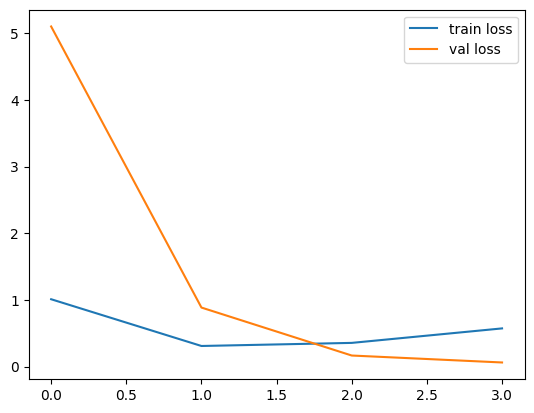

In [97]:
loss_history = train(model, optim, criterion, train_dataloader, val_dataloader, epoches=4)

### Testing 

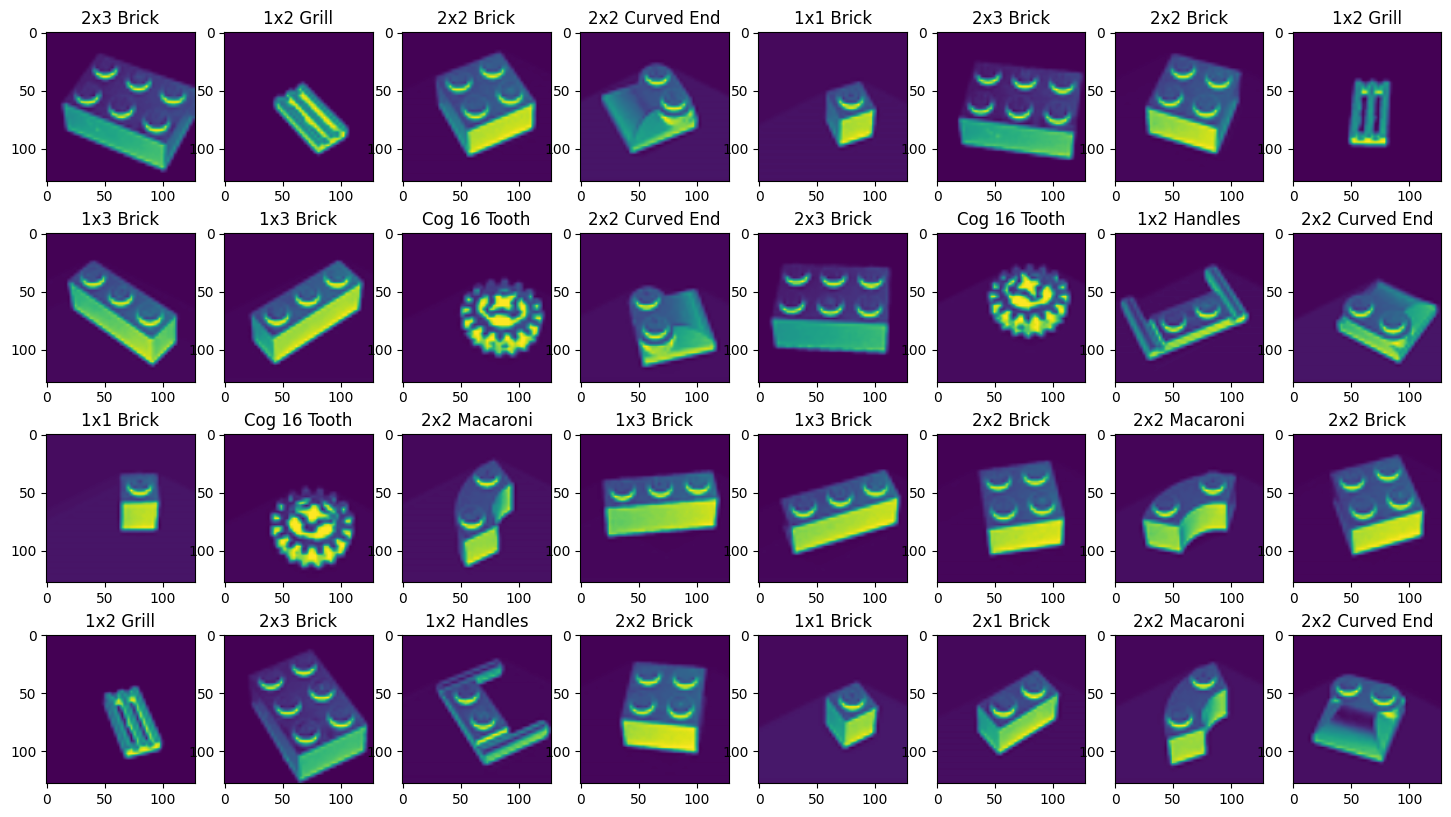

In [98]:
X, _ = next(iter(val_dataloader))

softmax = nn.Softmax(dim=1)
model.eval()

with torch.no_grad():
    y = softmax(model(X.to(device))).cpu().detach().numpy()
    X = X.cpu().detach().numpy()

rows, cols = 4, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, 10))

for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(X[i], (1, 2, 0)))
    axs[r, c].title.set_text(label2text(np.argmax(y[i])))

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
def accuracy(model, val_dataloader):
    model.eval()

    s = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dataloader):
            y_pred = model(X_batch.to(device)).cpu().detach().numpy()
            y_pred = np.argmax(y_pred, axis=1)
            s += accuracy_score(y_batch.numpy(), y_pred)
    
    s /= len(val_dataloader)

    return s

In [101]:
accuracy(model, val_dataloader)

100%|██████████| 5/5 [00:00<00:00, 166.63it/s]


0.98125